In [1]:
import pandas as pd
import numpy as np
from scipy import stats
import matplotlib.pyplot as plt
import statsmodels.api as sm
import statsmodels.formula.api as smf
import matplotlib.pyplot as plt

# Import data
DJ_data = pd.read_excel('DJ_Data.xlsx', header = 2, converters = {'API10': str})

# Add data transformations
DJ_data['LN_OIL_EUR'] = np.log(DJ_data['OIL EUR, MBBL'])
DJ_data['LN_GAS_EUR'] = np.log(DJ_data['GAS EUR, MMCF'])
DJ_data['LN_OIL_12MO'] = np.log(DJ_data['12-MO CUMULATIVE OIL'])
DJ_data['LN_GAS_12MO'] = np.log(DJ_data['12-MO CUMULATIVE GAS'])
DJ_data['LN_OIL_IP'] = np.log(DJ_data['OIL IP, BBL/MO'])
DJ_data['LN_GAS_IP'] = np.log(DJ_data['GAS IP, MCF/MO'])
DJ_data['Fluid_Intensity'] = DJ_data['TOTAL_FLUID'] / DJ_data['LATERAL_LENGTH']
DJ_data['Prop_Intensity'] = DJ_data['TOTAL_PROPPANT'] / DJ_data['LATERAL_LENGTH']

In [2]:
# Index dataframe
C = DJ_data.keys()
R = DJ_data.index

# Filter to datasets for use in regression
NBRR_oil = DJ_data[(DJ_data['OIL_COMPLETE'] == True) & (DJ_data['FORMATION'] == 'NBRR')]
NBRR_gas = DJ_data[(DJ_data['GAS_COMPLETE'] == True) & (DJ_data['FORMATION'] == 'NBRR')]
CDLL_oil = DJ_data[(DJ_data['OIL_COMPLETE'] == True) & (DJ_data['FORMATION'] == 'CDLL')]
CDLL_gas = DJ_data[(DJ_data['GAS_COMPLETE'] == True) & (DJ_data['FORMATION'] == 'CDLL')]

# Print column headers
C

Index(['API10', 'SQL', 'API10_NUM', 'State', 'Survey Source', 'Center_Lat',
       'Center_Lon', 'Center_Y', 'Center_X', 'OIL EUR, MBBL', 'GAS EUR, MMCF',
       '12-MO CUMULATIVE OIL', '12-MO CUMULATIVE GAS', 'OIL IP, BBL/MO',
       'GAS IP, MCF/MO', 'FORMATION', 'SUBZONE', 'Zone Source',
       'First Production Date', 'Vintage Include', 'Trajectory',
       'LATERAL_LENGTH', 'TOTAL_PROPPANT', 'TOTAL_FLUID', 'OIL_API', 'GOR',
       'WATER_YIELD', 'Zone_MIN_DISTANCE', 'Subzone_MIN_DISTANCE', 'Bearing',
       'TVD_ACTUAL', 'NET PAY', 'PHIH', 'POROSITY', 'RESISTIVITY', 'SOPHIH',
       'TEMPERATURE', 'TVD', 'WATER SATURATION', 'OIL_COMPLETE',
       'GAS_COMPLETE', 'LN_OIL_EUR', 'LN_GAS_EUR', 'LN_OIL_12MO',
       'LN_GAS_12MO', 'LN_OIL_IP', 'LN_GAS_IP', 'Fluid_Intensity',
       'Prop_Intensity'],
      dtype='object')

In [3]:
# Check independent variables for multicollinearity, vif values exceeding 5 or 10 indicates high multicollinarity
from statsmodels.stats.outliers_influence import variance_inflation_factor

indep_vars = NBRR_oil[['LATERAL_LENGTH', 'Fluid_Intensity', 'Prop_Intensity', 'GOR', 'WATER_YIELD', 'SOPHIH']]
vif = pd.DataFrame()
vif['variables'] = indep_vars.columns
vif['VIF'] = [variance_inflation_factor(indep_vars.values, r) for r in range(indep_vars.shape[1])]
vif

,variables,VIF
0,LATERAL_LENGTH,6.623277
1,Fluid_Intensity,6.347701
2,Prop_Intensity,5.856124
3,GOR,3.182793
4,WATER_YIELD,1.104743
5,SOPHIH,6.170222


In [4]:
# NBRR oil EUR model
""" 
String that represents regression formula is written in patsy.
Patsy is a Python package for describing statistical models and building design matrices. 
It is closely inspired by and compatible with the ‘formula’ mini-language used in R and S
"""

NBRR_OIL_EUR_model = smf.ols('LN_OIL_EUR ~ np.log(GOR) + I(WATER_YIELD ** (1/8)) + np.log(Fluid_Intensity)'
                             + ' + np.log(LATERAL_LENGTH) + np.log(Prop_Intensity) + I(SOPHIH ** 0.5)',
                             data = NBRR_oil).fit()
print(NBRR_OIL_EUR_model.summary())

                            OLS Regression Results                            
Dep. Variable:             LN_OIL_EUR   R-squared:                       0.674
Model:                            OLS   Adj. R-squared:                  0.674
Method:                 Least Squares   F-statistic:                     1564.
Date:                Thu, 05 Aug 2021   Prob (F-statistic):               0.00
Time:                        17:29:13   Log-Likelihood:                -1340.7
No. Observations:                4538   AIC:                             2695.
Df Residuals:                    4531   BIC:                             2740.
Df Model:                           6                                         
Covariance Type:            nonrobust                                         
                                coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------------
Intercept             

In [5]:
coefs = NBRR_OIL_EUR_model.params
coefsindex = coefs.index
coefsindex

Index(['Intercept', 'np.log(GOR)', 'I(WATER_YIELD ** (1 / 8))',
       'np.log(Fluid_Intensity)', 'np.log(LATERAL_LENGTH)',
       'np.log(Prop_Intensity)', 'I(SOPHIH ** 0.5)'],
      dtype='object')

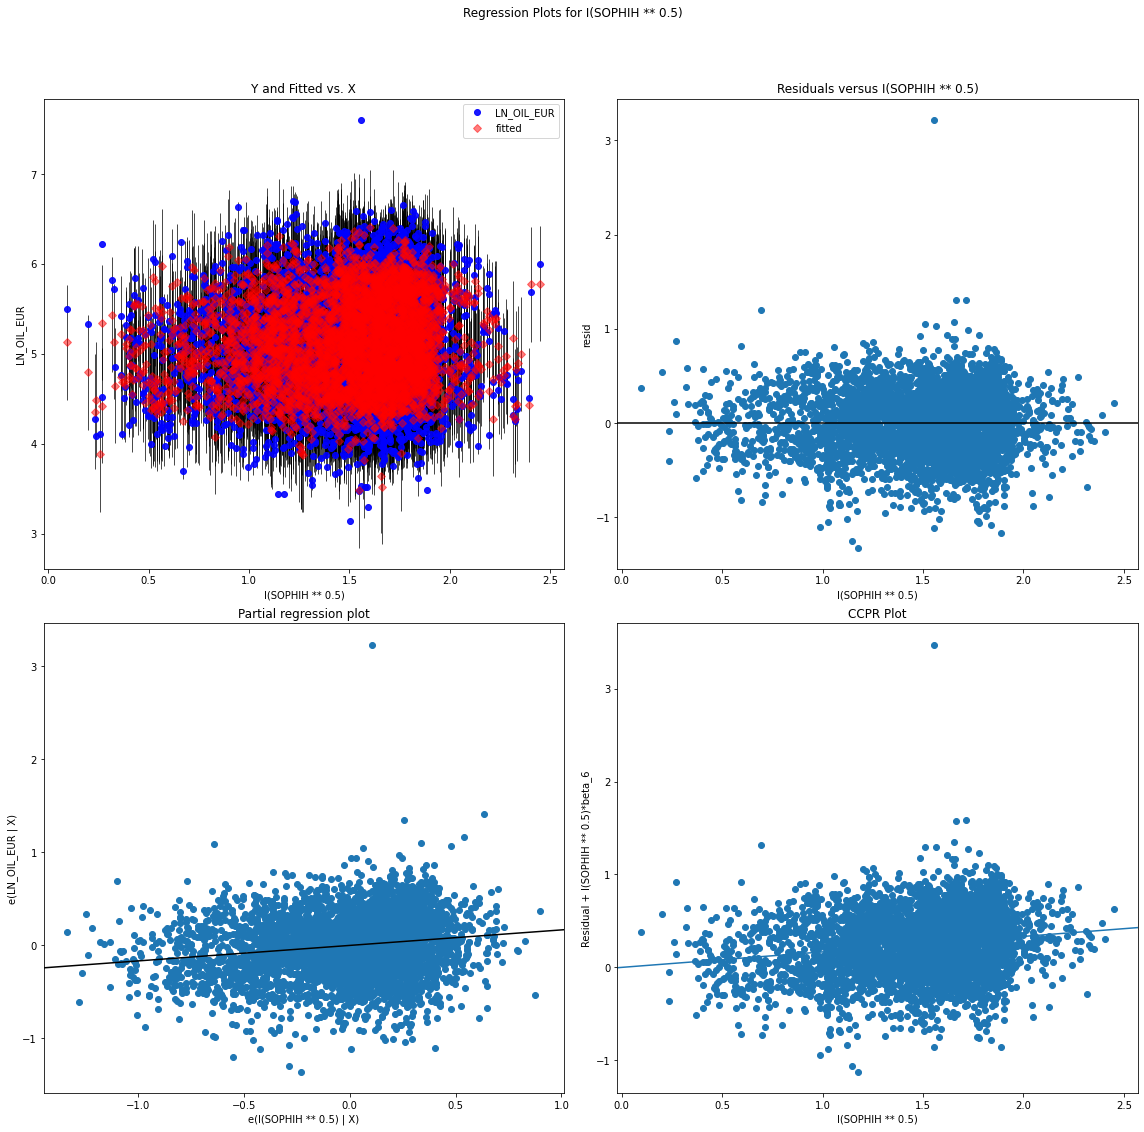

In [6]:
# Regression plot for a selected independent variable
plt.rc("figure", figsize=(16,16))
plt.rc("font", size=10)

results_plot = sm.graphics.plot_regress_exog(NBRR_OIL_EUR_model, coefsindex[6]) # Change index number to plot different variable

In [7]:
NBRR_oil_result = pd.DataFrame(NBRR_oil['API10'].astype(str))
NBRR_oil_result['NBRR_OIL_EUR_RESID'] = NBRR_OIL_EUR_model.resid
NBRR_oil_result['NBRR_OIL_EUR_PRED'] = NBRR_oil['OIL EUR, MBBL'] / np.exp(NBRR_OIL_EUR_model.resid)
Params = pd.DataFrame(NBRR_OIL_EUR_model.params)
NBRR_oil_result.to_excel('NBRR_oil.xlsx', sheet_name = 'NBRR_OIL_EUR')
with pd.ExcelWriter('NBRR_oil.xlsx', engine = 'openpyxl', mode = 'a') as writer:
    Params.to_excel(writer, sheet_name = 'NBRR_OIL_EUR_Coefs')

In [8]:
# Print regression equation

regeq = round(coefs[0], 3)
cnt = 1
for i in coefs[1:]:
    regeq = f'{regeq} + {round(i, 3)} {coefsindex[cnt]}'
    cnt = cnt + 1
print(regeq)

-1.473 + -0.404 np.log(GOR) + -0.966 I(WATER_YIELD ** (1 / 8)) + 0.298 np.log(Fluid_Intensity) + 0.957 np.log(LATERAL_LENGTH) + 0.137 np.log(Prop_Intensity) + 0.167 I(SOPHIH ** 0.5)


In [9]:
# Normalize predictions to specific operating parameters
LL = 9900
PropInt = 2000
FluidInt = 1500

NBRR_OIL_EUR_NORM = coefs[0] + coefs[1] * np.log(NBRR_oil['GOR']) + coefs[2] * NBRR_oil['WATER_YIELD'] ** (1/8) + coefs[3] * np.log(FluidInt) + coefs[4] * np.log(LL) + coefs[5] * np.log(PropInt) + coefs[6] * NBRR_oil['SOPHIH'] ** 0.5

In [10]:
# Write normalized predictions to Excel
NBRR_oil_result['NBRR_OIL_EUR_NORM'] = np.exp(NBRR_OIL_EUR_NORM)
with pd.ExcelWriter('NBRR_oil.xlsx', engine = 'openpyxl', mode = 'a') as writer:
    NBRR_oil_result.to_excel(writer, sheet_name = 'NBRR_OIL_EUR_NORM')